### Setting Up The Environment

In [1]:
import numpy as np
import pandas as pd
import os
from os import listdir
import cv2
import matplotlib.pyplot as plt
import imutils
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from sklearn.metrics import f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, roc_curve
import seaborn as sns

In [2]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


### Getting Insights About Data

In [15]:
os.listdir('brain_tumor_dataset')

['augmented', 'no', 'yes']

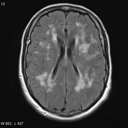

In [4]:
#showing image of non-tumor
im = Image.open('brain_tumor_dataset/no/44no.jpg').resize((128, 128))
im

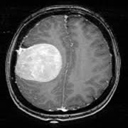

In [5]:
#showing image of tumor
im = Image.open('brain_tumor_dataset/yes/Y1.jpg').resize((128, 128))
im

In [17]:
#setting the directory of our data
yes = os.listdir('brain_tumor_dataset/yes')
no = os.listdir('brain_tumor_dataset/no')

#concate two data
data = np.concatenate([yes,no])
assert (len(data) == len(yes)+len(no))

#mapping our classes to 1 and 0. 1 == yes and 0 == no
target_x = np.full(len(yes),1)
target_y = np.full(len(no),0)

#label of our data
data_target = np.concatenate([target_x,target_y])

assert (len(data_target) == len(target_x)+len(target_y))
assert (len(data_target) == len(data))

print(len(target_x), len(target_y))

1239 1176


### Data Augmentation

In [7]:
#function for data augmentation

def augment_data(file_dir, n_generated_samples, save_to_dir):
    
  #ImageDataGenerator generates new images by applying some transformation 
  data_gen = ImageDataGenerator(rotation_range=10, 
                                width_shift_range=0.1, 
                                height_shift_range=0.1, 
                                shear_range=0.1, 
                                brightness_range=(0.3, 1.0),
                                horizontal_flip=True, 
                                vertical_flip=True, 
                                fill_mode='nearest'
                               )

  for filename in listdir(file_dir):
    image = cv2.imread(file_dir + '/' + filename)
    # reshape the image
    image = image.reshape((1,)+image.shape)
    save_prefix = 'aug_' + filename[:-4]
    i=0
    for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
      i += 1
      if i > n_generated_samples:
        break

In [8]:
# Saves augmented image in the specified directory for future use
"""
augmented_dir='C:/Users/DELL/Desktop/AML_Mini_Project/brain_tumor_dataset/augmented/'
image_dir='C:/Users/DELL/Desktop/AML_Mini_Project/brain_tumor_dataset/'
augment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_dir+'yes')
augment_data(file_dir=image_dir+'no', n_generated_samples=10, save_to_dir = augmented_dir+'no')

"""

"\naugmented_dir = '/content/drive/My Drive/SoftComputingProject/Dataset/augmented-images/'\nimage_dir = '/content/brain_tumor_dataset/'\n\naugment_data(file_dir=image_dir+'yes',n_generated_samples=6, save_to_dir=augmented_dir+'yes')\naugment_data(file_dir=image_dir+'no', n_generated_samples=10, save_to_dir = augmented_dir+'no')\n\n"

### Data Prepocessing

In [18]:
#Setting the height and width of the image for our model
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMAGE_SIZE = [IMG_HEIGHT, IMG_WIDTH]

In [19]:
X_data = []

#reading images from directory, resizeing to IMG_HEIGHT * IMG_WIDTH * 3 and appending images to a list
for file in yes:
  img = cv2.imread('brain_tumor_dataset/yes/'+file)
  img2 = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  (b, g, r) = cv2.split(img2) 
  img = cv2.merge([r,g,b])
  X_data.append(img)

for file in no:
  img = cv2.imread('brain_tumor_dataset/no/'+file)
  img2 = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
  (b, g, r) = cv2.split(img2) 
  img = cv2.merge([r,g,b])
  X_data.append(img)

X_data = np.squeeze(X_data)
assert (len(X_data) == len(data) == len(data_target))


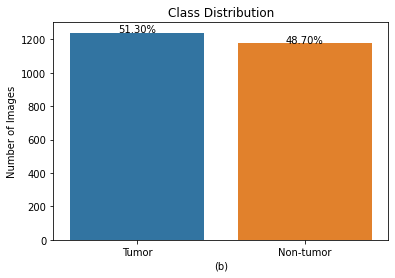

In [20]:
import seaborn as sns

labels = []
for x in data_target:
  if x == 0:
    labels.append('Non-tumor')
  else:
    labels.append('Tumor')

total = len(labels)

#sns.set(style="darkgrid")
ax = sns.countplot(x=labels)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height*100/total),
            ha="center") 

plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.xlabel('(b)')
plt.show()

In [21]:
# function for cropping the brain out of the image using OpenCV
def crop_imgs(set_name, add_pixels_value=0):
  """
  Finds the extreme points on the image and crops the rectangular out of them
  """
  set_new = []
  for img in set_name:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = add_pixels_value
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    new_img = cv2.resize(new_img, (IMG_HEIGHT, IMG_WIDTH))
    set_new.append(new_img)

  return np.array(set_new)

In [22]:
# apply crop function for all images
X = crop_imgs(set_name=X_data)


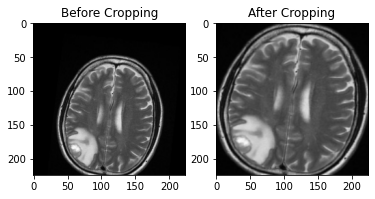

(224, 224, 3)


In [23]:
#image after cropping
plt.figure(figsize=(6,4))

#before cropping
plt.subplot(121)
plt.imshow(X_data[55])
plt.xticks(None)
plt.yticks(None)
plt.title('Before Cropping')

#after cropping
plt.subplot(122)
plt.imshow(X[55])
plt.xticks(None)
plt.yticks(None)
plt.title('After Cropping')

plt.show()

X_data[250].shape == X[250].shape
print(X[250].shape)


In [24]:
# normalize data
X = X.astype('float32')
X /= 255

In [25]:
# split the data into 75:15:15 ratio
X_train, X_test, y_train, y_test = train_test_split(X, data_target, random_state=50, test_size=0.15, stratify = data_target)

print(len(y_train))
print(len(y_test))


2052
363


### VGG-19 Architecture

In [26]:
# VGG19 model is pre-trained with imagenet data 
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

NUM_CLASSES = 1

# vgg19 + dropout + flatten + dropout + dense

vgg19 = Sequential()
vgg19.add(vgg)
vgg19.add(layers.Dropout(0.3))
vgg19.add(layers.Flatten())
vgg19.add(layers.Dropout(0.5))
vgg19.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# all the vgg-19 layers except for the last layer is non-trainable
vgg19.layers[0].trainable = False

vgg19.summary()


80150528/80134624 [==============================] - 17s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 dropout (Dropout)           (None, 7, 7, 512)         0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_______________________________________

In [27]:
# defining cost function and optimization method
from keras.optimizer_v2.adam import Adam as Adam


vgg19.compile(
    loss='binary_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, 
                                    epsilon=None, decay=0.0, amsgrad=False), 
    metrics=["acc"]
    )

F:\Anaconda\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
#checkpoint which stores the weights of the model when maximum validation accuracy is found
checkpoint_filepath = "weights.best.hdf5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

history = vgg19.fit(X_train, y_train, batch_size = 64, 
                    epochs = 5, validation_split = 0.18, callbacks=[checkpoint])

Epoch 1/5
27/27 [==============================] - 571s 21s/step - loss: 1.6904 - acc: 0.7307 - val_loss: 0.4781 - val_acc: 0.8432
Epoch 2/5
27/27 [==============================] - 639s 24s/step - loss: 0.4379 - acc: 0.8716 - val_loss: 0.3344 - val_acc: 0.9027
Epoch 3/5
27/27 [==============================] - 643s 24s/step - loss: 0.2645 - acc: 0.9049 - val_loss: 0.1602 - val_acc: 0.9351
Epoch 4/5
27/27 [==============================] - 659s 25s/step - loss: 0.1963 - acc: 0.9340 - val_loss: 0.1752 - val_acc: 0.9351
Epoch 5/5
27/27 [==============================] - 629s 23s/step - loss: 0.1292 - acc: 0.9530 - val_loss: 0.1206 - val_acc: 0.9568


### Model Evaluation

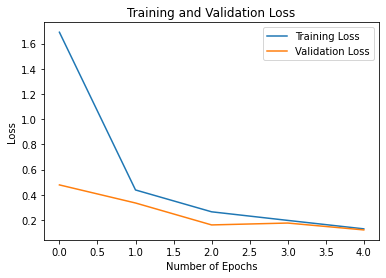

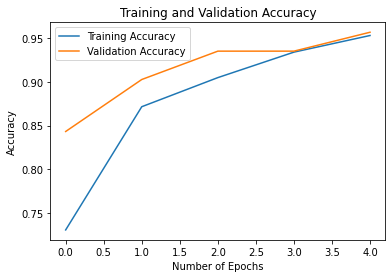

In [30]:
history = vgg19.history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['acc']
val_acc = history['val_acc']


    
# Loss
plt.figure()
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
    
# Accuracy#
plt.figure()
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



In [31]:
# Evaluate the model on test set
score = vgg19.evaluate(X_test, y_test, verbose=0) 

# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.9641873240470886


In [32]:
y_hat = vgg19.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_hat]

#metrics calculation

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)

# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

# specificity calculation
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
print('Specificity: ',specificity)

#classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.964187
Precision: 0.977901
Recall: 0.951613
F1 score: 0.964578
Cohens kappa: 0.928380
ROC AUC: 0.964507
[[173   4]
 [  9 177]]
Specificity:  0.9774011299435028
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       177
           1       0.98      0.95      0.96       186

    accuracy                           0.96       363
   macro avg       0.96      0.96      0.96       363
weighted avg       0.96      0.96      0.96       363



<AxesSubplot:>

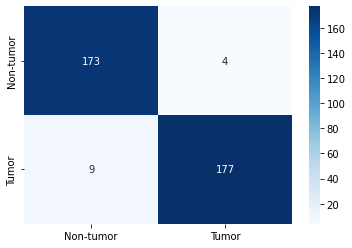

In [33]:
# plot confusion matrix
categories = ['Non-tumor', 'Tumor']
df_matrix = pd.DataFrame(matrix, index = categories, columns = categories)
sns.heatmap(df_matrix, annot=True, cmap='Blues', fmt='d')


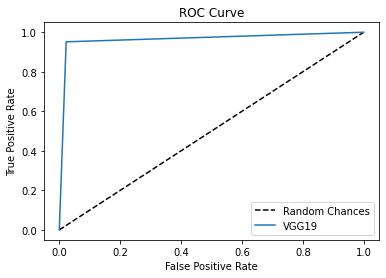

In [34]:
#ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chances')
plt.plot(fpr, tpr, label='VGG19')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show();

In [35]:
#index 0 = No , index 1 = Yes
labels = ["No", "Yes"]


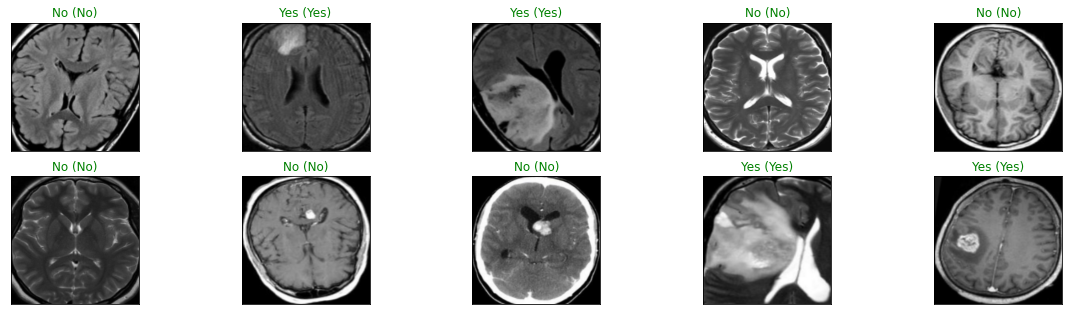

In [36]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))

for i, index in enumerate(np.random.choice(X_test.shape[0], size=10, replace=False)):
  ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
  # Display each image
  ax.imshow(np.squeeze(X_test[index]))
  predict_index = y_pred[index]
  true_index = y_test[index]
  # Set the title for each image
  ax.set_title("{} ({})".format(labels[predict_index], 
                                  labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))
plt.show()